# Example: Satellite Profile Methodology

Last Verified to Run: 2023-10-20\
Verified Stack Release: w_2023_42

## Introduction

The purpose of this notebook is to demonstrate the usage and methodology used by the LEOSim module to create realistic surface brightness profiles of Low-Earth orbit satellites. This involves introducing the major object definitions used by the module and demonstrating the calculation of surface brightness profiles for a number of different satellite geometries.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   g4213664e8e+a91833641f 	w_latest current w_2023_42 setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import galsim

from leosim import DiskSatellite, Instrument

## Introduction to the `Instrument` Class

The `Instrument` class represents a telescope, defined by the primary mirror geometry, and a camera, defined by camera properties. Below, an `Instrument` object is initialized from the primary mirror outer radius (in meters), primary mirror inner radius (in meters), and the camera pixel scale (in arcseconds per pixel). The LEOSim module relies heavily on the usage of the `astropy.units` package, and almost all physical quantities used by the different class definitions are required to be defined as `astropy.units.Quantity` objects, with a specific unit. This was done in order to more easily obtain the proper unit conversions when calculating derived quantities such as velocities, angular velocities, and angular size.

The instrument created below has the same properties as the LSST Camera (8.4 meter primary mirror).

In [3]:
## Define an instrument
outer_radius = 4.18*u.m
inner_radius = 2.558*u.m
pixel_scale = 0.2*u.arcsec/u.pix

instrument = Instrument(outer_radius, inner_radius, pixel_scale)

The `Instrument` class uses the `rubin_sim` package to initialize `rubin_sim.phot_utils.Bandpass` objects that represent different filter bandpasses, i.e. fractional throughput as a function of wavelength. These can be created using the `Instrument.get_bandpass()` function that accepts a bandpass name and returns the desired bandpass. 

Below we iterate through all the possible bandpass name values (u, g, r, i, z, y) and plot the throughput as a function of wavelength for each.

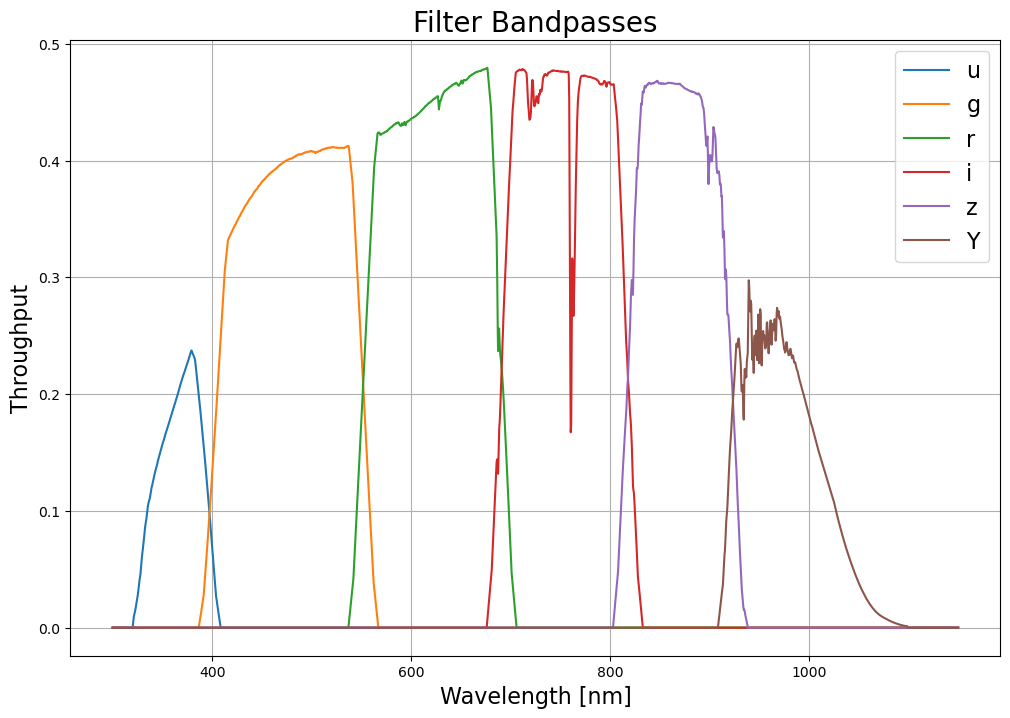

In [4]:
## Plot the LSST Camera bandpasses
fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')

bands = ['u', 'g', 'r', 'i', 'z', 'Y']
for band in bands:
    bandpass = instrument.get_bandpass(band)
    ax.plot(bandpass.wavelen, bandpass.sb, label=band)

ax.grid()
ax.set_ylabel('Throughput', fontsize=16)
ax.set_xlabel('Wavelength [nm]', fontsize=16)
ax.set_title('Filter Bandpasses', fontsize=20)
ax.legend(fontsize=16)

## Introduction to the `Satellite` Class

The next set of classes consist of child classes of the `BaseSatellite` class and represent a satellite, with its corresponding geometry and orbital parameters. The `BaseSatellite` class should never be used on its own; rather one of the child classes should be used, depending on the desired geometry of the satellite. However all child classes share some commonality with the `BaseSatellite` parent class that will be described. Fundamentally, all satellites require an orbital height (in kilometers) and an angle from zenith (in degrees), both defined as `astropy.units.Quantity` objects.

This example notebook will use the `DiskSatellite` class that represents a satellite whose reflective surface is shaped like a circular disk. For examples of the other satellite child classes see `Example_SatelliteTypes.ipynb`. The `DiskSatellite` class requires an additional initialization parameter, the radius of the satellite (in meters). For this example we create a disk satellite with 5 meter radius, orbiting at a height of 550 kilometers, and observed at a 40 degree angle from zenith.

In [5]:
## Define a satellite
height = 550*u.km
zangle = 40*u.deg
radius = 5.0*u.m

satellite = DiskSatellite(height, zangle, radius)

Before we proceed we want to establish a static scale (in arcseconds), that will be used by Galsim to create images of the profile. The scale is 1000 setps at 0.02 arcseconds, spanning a total extent of 20 arcseconds.

In [6]:
## Define profile scales
step_size = 0.02 
steps = 1000

smin = -int(steps*step_size/2)
smax = int(steps*step_size/2)
scale = np.linspace(smin, smax, steps)

### Satellite Profile

The first component of the satellite stationary surface brightness profile is the satellite profile. This can be accessed by the `Satellite.profile` attribute, which will calculate the relevant angular scales from the physical dimensions of the satellite and create a profile, represented by a `galsim.TopHat` object. We can then draw an image of the profile using the usual galsim `GSObject.drawImage()` method, using the scale defined above. As expected the satellite profile is a uniform circle, although now in units of arcseconds, as determined by the size of the satellite and the distance to the satellite.

Text(0.5, 0, 'arcsec')

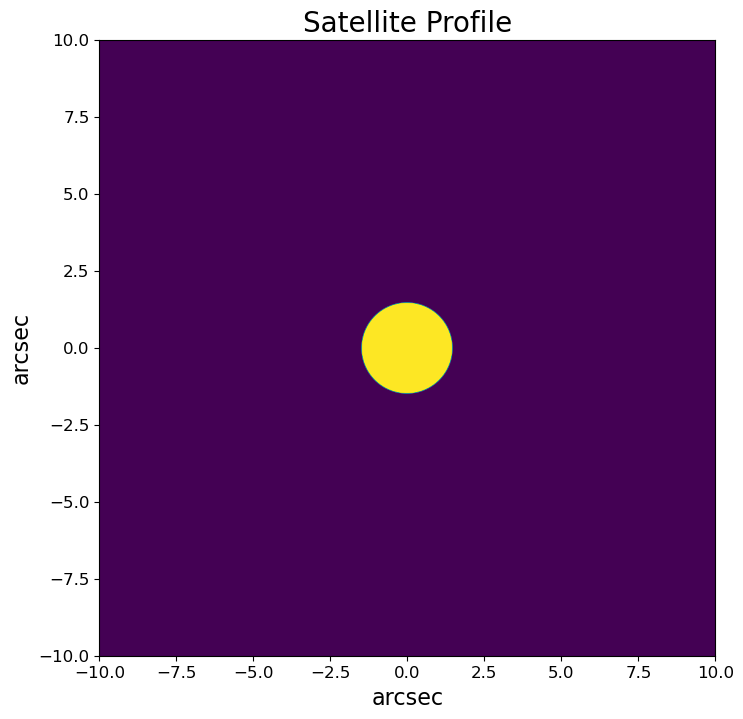

In [7]:
satellite_profile = satellite.profile
satellite_image = satellite_profile.drawImage(scale=step_size, nx=steps, ny=steps)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.imshow(satellite_image.array, origin='lower', extent=[smin, smax, smin, smax])
ax.set_title('Satellite Profile', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_ylabel('arcsec', fontsize=16)
ax.set_xlabel('arcsec', fontsize=16)

### Defocus Profile

The second component of the satellite stationary profile is the defocus profile. Because telescopes are focused at infinity, objects that are relatively close to the telescope will be defocused. The defocus profile used to create this effect will be a angularly scaled version of the telescope pupil. Using an `Instrument` object, we can calculate the defocus profile for a given satellite using the `Satellite.get_defocus_profile()` method, which returns a `galsim.GSObject` representing the telescope pupil.  As before we can draw the image using our defined scale.

Text(0.5, 0, 'arcsec')

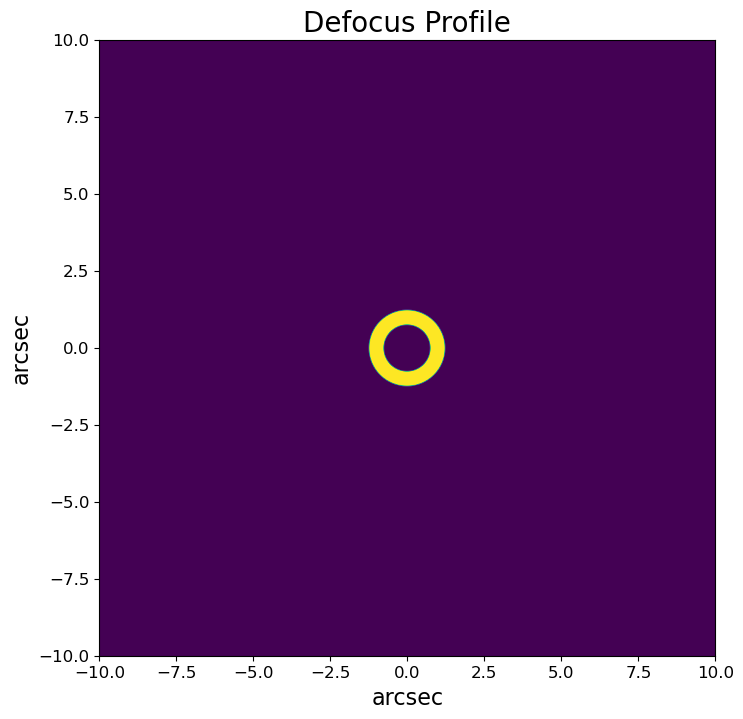

In [8]:
defocus_profile = satellite.get_defocus_profile(instrument)
defocus_image = defocus_profile.drawImage(scale=step_size, nx=steps, ny=steps)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.imshow(defocus_image.array, origin='lower', extent=[smin, smax, smin, smax])
ax.set_title('Defocus Profile', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_ylabel('arcsec', fontsize=16)
ax.set_xlabel('arcsec', fontsize=16)

### Atmospheric Profile

The final component of the satellite stationary profile is the atmospheric PSF profile. To represent the effect of atmospheric turbulence we rely simply on the relevant Galsim classes (e.g. Kolmogorov or VonKarman). Below we define the atmospheric PSF profile as a Kolmogorov profile with full-width-half-maximum of 0.67 arc seconds and draw the image.

Text(0.5, 0, 'arcsec')

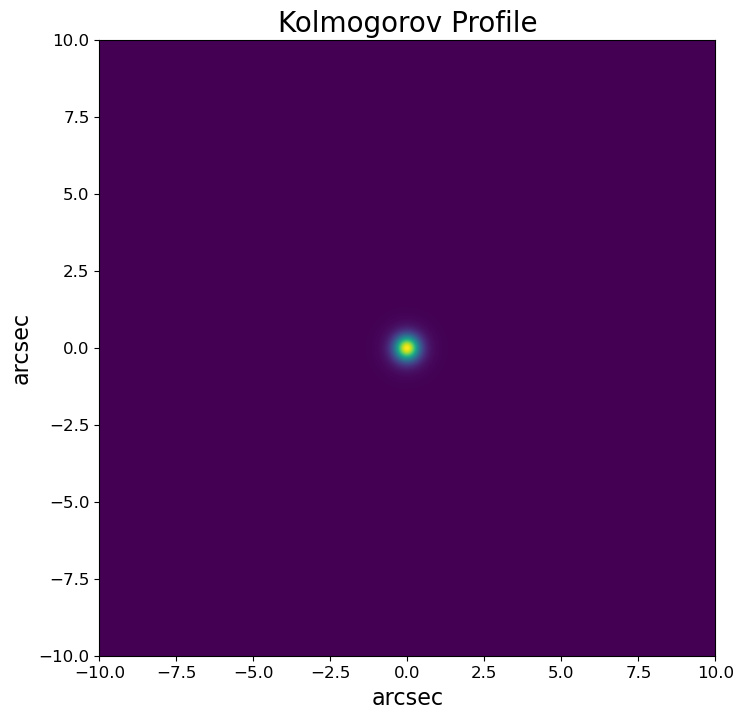

In [9]:
seeing_profile = galsim.Kolmogorov(fwhm=0.67)
seeing_image = seeing_profile.drawImage(scale=step_size, nx=steps, ny=steps)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.imshow(seeing_image.array, origin='lower', extent=[smin, smax, smin, smax])
ax.set_title('Kolmogorov Profile', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_ylabel('arcsec', fontsize=16)
ax.set_xlabel('arcsec', fontsize=16)

### Satellite Stationary Profile

We can now create the satellite stationary surface brightness profile using the `Satellite.get_stationary_profile()` method, which accepts a seeing profile and an instrument and returns a `galsim.GSObject`. This method convolves the satellite profile, the defocus profile, and the seeing profile to create the stationary surface brightness profile.

Text(0.5, 0, 'arcsec')

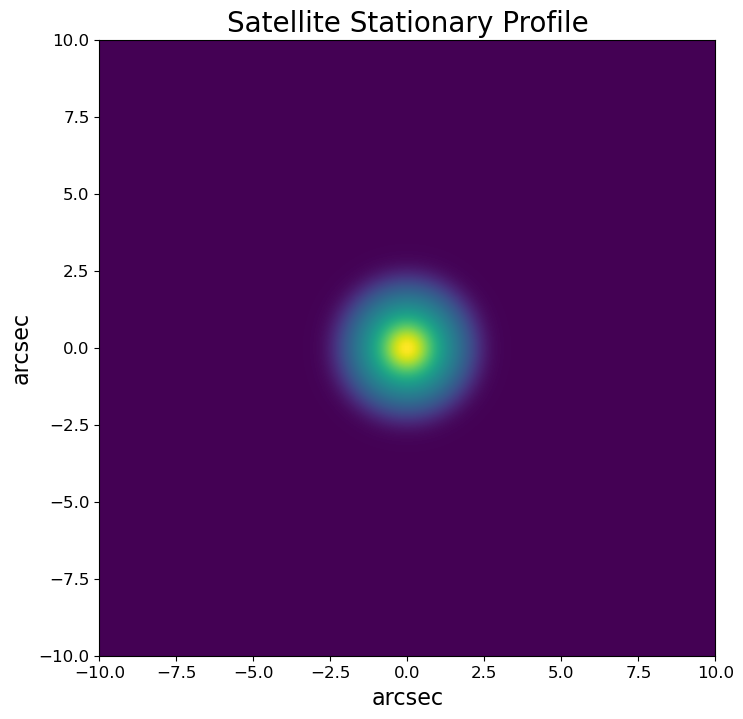

In [10]:
stationary_profile = satellite.get_stationary_profile(seeing_profile, instrument)
stationary_image = stationary_profile.drawImage(scale=step_size, nx=steps, ny=steps)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.imshow(stationary_image.array, origin='lower', extent=[smin, smax, smin, smax])
ax.set_title('Satellite Stationary Profile', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_ylabel('arcsec', fontsize=16)
ax.set_xlabel('arcsec', fontsize=16)

We are also interested in the cross-sectional profile of the satellite streak caused by the satellite traversing the focal plane along its flight direction over the course of the exposure integration time. Below we calculate the normalized streak cross-sectional profile by summing the image array over one axis, and normalizing by the maximum value.

Text(0.5, 0, 'arcsec')

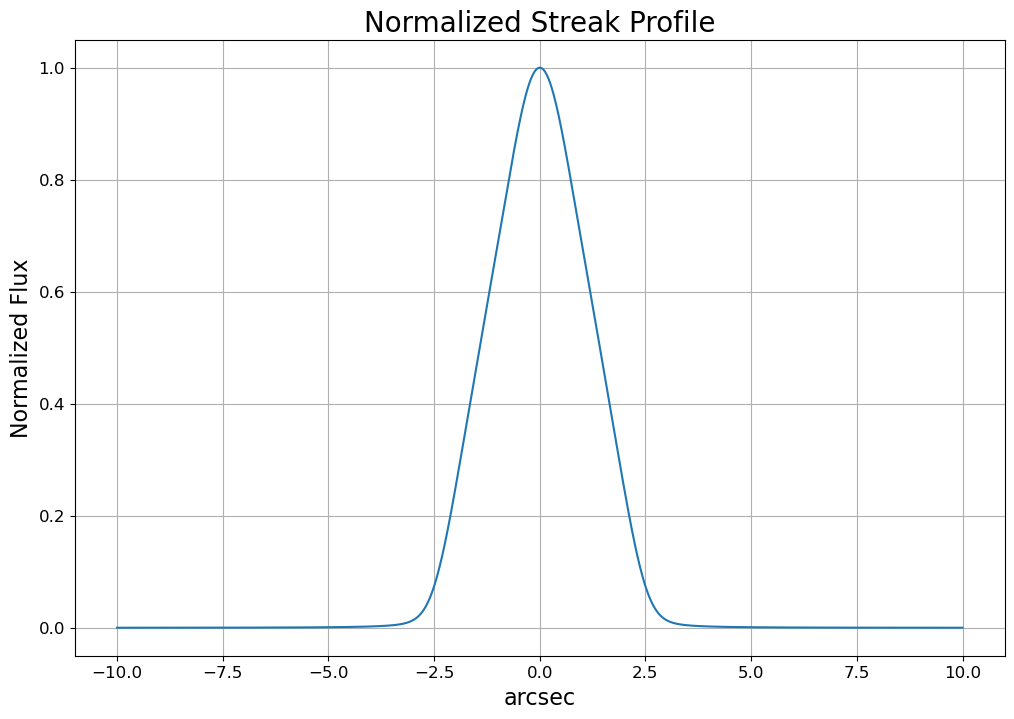

In [11]:
cross_section = stationary_image.array.sum(axis=0)
normalized_cross_section = cross_section/np.max(cross_section)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')
ax.plot(scale, normalized_cross_section)
ax.grid()
ax.set_title('Normalized Streak Profile', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_ylabel('Normalized Flux', fontsize=16)
ax.set_xlabel('arcsec', fontsize=16)